# OOP-Scene-Generation

In [1]:
from graphviz import Digraph
import pyro
import torch
pyro.set_rng_seed(101)

import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt

import numpy as np
from collections import Counter
from googlesearch import search
from ipywidgets import interactive, Layout
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import os
#os.pathsep + r'your_graphviz_bin_direction'

This is an object-oriented causal effect model which can generate a reasonable image from the model result.

In the model, we have 2 agents: a person and an animal. There are some interactions between them and the interaction is conditioned on their position(locality) and the environment(background). Condition or intervention on their attributes will affect the final generated image.

Here are the attributes of each class: <br>
Person： position1， haircolor， hairlength， gender， age <br>
Animal： position2, color, size, type <br>
Background： background <br>
Interaction： interaction

## DAG

The model we designed includs 2 agents: a person and and animal, they will have some different interactions if their environment and position change. Here is the DAG for this model.

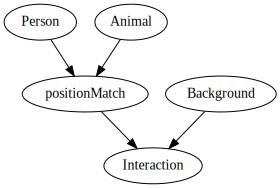

In [2]:
dag = Digraph(comment='DAG')
dag.node('P','Person')
dag.node('A','Animal')
dag.node('M','positionMatch')
dag.node('B','Background')
dag.node('I','Interaction')
dag.edges(['PM', 'AM', 'MI', 'BI'])
dag

## Model

### Pre-defined Probabality Distribution
The probability distribution are defined based on the logic showed in the DAG: the postions of two entities and the background will determine their final interactions. The positions can be left or right indicates they are in the left part of right part of the background.<br> 
In our definition, there are four types of interations: 'fight','hold', 'chase', and 'call'. 'fight' and 'hold' occur when they have the same postion while 'chase' and 'call' occur only if they have different positions.<br>
Their interaction is also limited by the environment they are in, which is the background of our final generated image. They can't 'hold' each other in the park and they can't 'chase' each other at home.

In [3]:
alias = {'position1':['left','right'], 
         'position2':['left','right'], 
         'haircolor':['black', 'brown', 'golden'],
         'hairlength':['short','long'],
         'gender':['male','female'],
         'age':['young','old'],
         'color':['black', 'grey', 'brown'],
         'size':['little','large'],
         'type':['cat','dog'],
         'background':['in the park','at home'],
         'interaction':['fights','chases','calls','holds']
        }

prob = {'position1':torch.tensor([0.5,0.5]), 
        'position2':torch.tensor([0.5,0.5]), 
        'haircolor':torch.tensor([1/3, 1/3, 1/3]),
        'hairlength':torch.tensor([0.5,0.5]),
        'gender':torch.tensor([0.5,0.5]),
        'age':torch.tensor([0.5,0.5]),
        'color':torch.tensor([1/3,1/3,1/3]),
        'size':torch.tensor([0.5,0.5]),
        'type':torch.tensor([0.5,0.5]),
        'background':torch.tensor([0.5,0.5]),
        'interaction':torch.tensor([[[[0.97,0.01,0.01,0.01],[0.01,0.49,0.49,0.01]], #park: e1=left, [e2=left. e2=right]
                                     [[0.01,0.49,0.49,0.01],[0.97,0.01,0.01,0.01]]], #park:e1=right, [e2=left. e2=right]
                                    [[[0.49,0.01,0.01,0.49],[0.01,0.01,0.97,0.01]], #home: e1=left, [e2=left. e2=right]
                                     [[0.01,0.01,0.97,0.01],[0.49,0.01,0.01,0.49]]]]) #home: e1=right, [e2=left. e2=right]
       }
causal_var = ['position1', 'position2', 'background', 'interaction']
other_var = ['haircolor', 'hairlength', 'gender', 'age', 'color', 'size', 'type']
infer_var = ['position1', 'position2', 'background', 'interaction']

### Define Person, Animal, Background, Interaction classes

In [4]:
class Person(object):
    def __init__(self):
        self.position1 = pyro.sample("position1", dist.Categorical(probs=prob['position1'])) 
        self.haircolor = pyro.sample("haircolor", dist.Categorical(probs=prob['haircolor']))
        self.hairlength = pyro.sample("hairlength", dist.Categorical(probs=prob['hairlength']))
        self.gender = pyro.sample("gender", dist.Categorical(probs=prob['gender']))
        self.age = pyro.sample("age", dist.Categorical(probs=prob['age']))
        
class Animal(object):
    def __init__(self):
        self.position2 = pyro.sample('position2', dist.Categorical(prob['position2']))
        self.color = pyro.sample('color', dist.Categorical(prob['color']))
        self.size = pyro.sample('size', dist.Categorical(prob['size']))
        self.type = pyro.sample('type', dist.Categorical(prob['type']))
        
class Background(object):
    def __init__(self):
        self.background = pyro.sample('background', dist.Categorical(prob['background']))
        
class Interaction(object):
    def __init__(self, entity1, entity2, background):
        self.interaction = pyro.sample('interaction', dist.Categorical(prob['interaction'][background.background][entity1.position1][entity2.position2]))

### Define Condition and Intervention Models 

In [5]:
def model():
    '''
    This is the basic overall model, all distributions are pre-defined at the beginning, 
    and relationships are in the definition of each class.
    '''
    person = Person()
    animal = Animal()
    background = Background()
    interaction = Interaction(person, animal, background)
    
def condition(model, evidence, num_samples = 1000):
    '''
    causal condition model, return posterior
    '''
    condition_model = pyro.condition(model, data=evidence)
    posterior = pyro.infer.Importance(condition_model, num_samples=num_samples).run()
    return posterior

def intervention(model, evidence, num_samples = 1000):
    '''
    causal intervention model, return posterior
    '''
    do_model = pyro.do(model, data=evidence)
    posterior = pyro.infer.Importance(do_model, num_samples=num_samples).run()
    return posterior
        
def pltDistribution(posterior, infer, num_samples = 1000):
    '''
    This function uses posterior from model to generated samples and plot the distribution of inference variables.
    '''
    sample = []
    for i in range(num_samples):
        trace = posterior()
        value = []
        for i in range(len(infer)):
            value.append(int(trace.nodes[infer[i]]['value']))
        sample.append(tuple(value))
        
    data = Counter(sample).most_common()
    unique = list(map(lambda x: x[0], data)) 
    counts = list(map(lambda x: x[1], data))

    x_label = []
    for i in range(len(unique)):
        label = []
        for j in range(len(infer)):
            label.append(alias[infer[j]][list(unique[i])[j]])
        x_label.append(label)

    plt.bar(range(len(data)), counts)
    plt.xticks(range(len(data)), x_label)
    plt.xlabel(infer)
        
def mostOccurance(posterior, infer, num_samples = 1000):
    '''
    This function takes the posterior from model and generated samples, then return the sample with most occurance.
    '''
    sample = []
    for i in range(num_samples): 
        trace = posterior()
        value = []
        for i in range(len(infer)):
            value.append(int(trace.nodes[infer[i]]['value']))
        sample.append(tuple(value))

    most_common, num_most_common = Counter(sample).most_common(1)[0]
    
    infer_dict = {}
    for i in range(len(infer)):
        infer_dict[infer[i]] = most_common[i]
    return infer_dict

### Define assistant functions

In [14]:
def getVar(w):
    '''
    This function takes all variables which have pre-defined values, 
    distinguishes them into causal model related variables and other variables,
    and converts label strings to torch.tensor().
    '''
    do_var = w.kwargs
    do_causal_var = {}
    do_other_var = {}
    for var in causal_var:
        if do_var[var] == '-':
            continue
        else:
            do_causal_var[var] = torch.tensor(alias[var].index(do_var[var]))
    for var in other_var:
        if do_var[var] == '-':
            continue
        else:
            do_other_var[var] = torch.tensor(alias[var].index(do_var[var]))
    return do_causal_var, do_other_var

def getInfer(do_causal_var):
    '''
    This function removes variables that has pre-defined values from all potential inference
    variables. It aims to only take variables which do not have pre-defined values as inferences 
    in our model.
    '''
    infer_all = infer_var.copy()
    do_causal_var_key = list(do_causal_var.keys())
    for var in do_causal_var_key:
        if var in infer_all:
            infer_all.remove(var)
    return infer_all

def getLabel(infer_res):
    '''
    This function convert torch.tensor() to label string for the dictionary with all variables.
    '''
    for key in infer_res:
        infer_res[key] = alias[key][infer_res[key]]
    return infer_res

def getEntity(input_dic):
    '''
    This function generates samples with pre-defined class and functions,
    and replace variables which have pre-defined values or infered from 
    our causal model.
    Return a dictionary with all variables with a label.
    '''
    dic = {}
    person = Person()
    animal = Animal()
    background = Background()
    interaction = Interaction(person,animal,background)
    entity_list = [person,animal,background,interaction]
    for k in entity_list:
        entity_dic = k.__dict__
        dic.update(entity_dic)
        
    for k in dic:
        dic[k] = alias[k][dic[k]]
    dic.update(input_dic)
    return dic

def getScene(input_dict):
    '''
    This function takes the output dictionary with all variable,
    and converts it into a sentence and print it out.
    '''
    scene = str("A %s %s with %s %s hair %s a %s %s %s %s." % 
                (input_dict['age'],input_dict['gender'],input_dict['haircolor'],input_dict['hairlength'],
                 input_dict['interaction'],input_dict['size'],input_dict['color'],input_dict['type'],
                 input_dict['background']))
    print(scene)
    return scene

def userInterface():
    '''
    This function allows user to do condition and intervention with a user interface.
    display(w) shows the interface.
    '''
    # Part 1: multiple choices of label values
    def f_interactive(position1,position2,haircolor,hairlength,gender,age,color,size,type,background,interaction):
        pass

    w = interactive(f_interactive, 
                       position1=sum([["-"],alias['position1']], []),
                       position2=sum([["-"],alias['position2']], []),
                       haircolor=sum([["-"],alias['haircolor']], []),
                       hairlength=sum([["-"],alias['hairlength']], []),
                       gender=sum([["-"],alias['gender']], []),
                       age=sum([["-"],alias['age']], []),
                       color=sum([["-"],alias['color']], []),
                       size=sum([["-"],alias['size']], []),
                       type=sum([["-"],alias['type']], []),
                       background=sum([["-"],alias['background']], []),
                       interaction=sum([["-"],alias['interaction']], []))
    
    # Part 2: button to show pictures
    btn_con = widgets.Button(description = "Show conditional picture", tooltip = 'condition button', layout=Layout(width='25%', height='40px'))
    btn_do = widgets.Button(description = "Show interventional picture", tooltip = 'intervention button', layout=Layout(width='25%', height='40px'))
    def btn_con_click(sender):
        final_dict, scene = model_condition(w, False)
        pic = generatePic(final_dict, scene)
        display(pic.finalImage)
        pic.save()
    def btn_do_click(sender):
        final_dict, scene = model_intervention(w, False)
        pic = generatePic(final_dict, scene)
        display(pic.finalImage)
        pic.save()
    btn_con.on_click(btn_con_click)
    btn_do.on_click(btn_do_click)

    return w, btn_con, btn_do

### Main functions

In [7]:
def model_condition(w, plot = False): 
    do_causal_var, do_other_var = getVar(w)
    infer = getInfer(do_causal_var)
    infer_model = condition(model, evidence = do_causal_var)
    do_causal_var.update(do_other_var)
    infer_res = {}
    if infer:
        if plot:
            pltDistribution(infer_model, infer)
        infer_res = mostOccurance(infer_model, infer)
    infer_res.update(do_causal_var)
    infer_res = getLabel(infer_res)
    final_dict = getEntity(infer_res)
    scene = getScene(final_dict)
    return final_dict, scene


def model_intervention(w, plot = False):
    do_causal_var, do_other_var = getVar(w)
    infer = getInfer(do_causal_var)
    infer_model = intervention(model, evidence = do_causal_var)
    do_causal_var.update(do_other_var)
    infer_res = {}
    if infer:
        if plot:
            pltDistribution(infer_model, infer)
        infer_res = mostOccurance(infer_model, infer)
    infer_res.update(do_causal_var)
    infer_res = getLabel(infer_res)
    final_dict = getEntity(infer_res)
    scene = getScene(final_dict)
    return final_dict, scene

## Image Generation

Image generation class takes the model result as input and generates an image using some basic picture entities like a person, a dog or a cat.
The interaction and other attributes of them are defined based on model result.

In [8]:
class generatePic(object):
    '''
    This class takes generated features from causal OOP model and implements it into a picture.
    '''
    def __init__(self, attr_dict, scene):
        self.position1 = attr_dict['position1']
        self.position2 = attr_dict['position2']
        self.haircolor = attr_dict['haircolor']
        self.hairlength = attr_dict['hairlength']
        self.gender = attr_dict['gender']
        self.age = attr_dict['age']
        self.type = attr_dict['type']
        self.size = attr_dict['size']
        self.color = attr_dict['color']
        self.background = attr_dict['background']
        self.scene = scene
        self.personImage, self.animalImage, self.backgroundImage = self.getImage()
        self.finalImage = self.getFinalImage()
        
    def getImage(self):
        '''
        load raw pictures as elements from local directory
        '''
        try:
            im_g = Image.open("./pic/"+self.gender+".png")
        except:
            im_g = Image.open("./pic/"+self.gender+".jpg")
        try:
            im_t = Image.open("./pic/"+self.type+".png")
        except:
            im_t = Image.open("./pic/"+self.type+".jpg")
        try:
            im_b = Image.open("./pic/"+self.background+".png")
        except:
            im_b = Image.open("./pic/"+self.background+".jpg")
        return im_g, im_t,im_b
            
    def hair(self):
        color_dict = {'golden':(255, 204, 0), 'black':'black', 'brown':(115, 77, 38)}
        fix_w = int(self.personImage.width/10)
        fix_h = int(self.personImage.height/6) if self.hairlength == 'short' else int(self.personImage.height/3)    
        for i in range(30):
            img1 = ImageDraw.Draw(self.personImage)
            shape = [(int(self.personImage.width/2)-20+i,int(self.personImage.height/20)),(fix_w,fix_h)]
            if i not in range(10,20):
                img1.line(shape,fill =color_dict[self.haircolor],width=2) 
            fix_w += 10

    def ages(self):
        if self.age == 'old':
            fix_w = int(self.personImage.width/2)
            fix_h = int(self.personImage.height/18)
            for i in range(4):
                img1 = ImageDraw.Draw(self.personImage)
                shape = [(fix_w-5*i,fix_h),(fix_w+5*i,fix_h)]
                img1.line(shape,fill ="white") 
                fix_h+=7
    
    def animal_color(self):
        color = self.color
        rgb_dict = {'black': (0, 0, 0),
                   'grey': (165, 169, 176),
                   'brown': (179, 120, 61)}
        self.animalImage = self.animalImage.convert('RGBA')
        data = np.array(self.animalImage)
        red, green, blue, alpha = data.T

        white_areas = (red == 255) & (blue == 255) & (green == 255)
        data[..., :-1][~white_areas.T] = rgb_dict[color]

        self.animalImage = Image.fromarray(data)
        
    def getSize(self):
        if self.size == 'little':
            rt = [0.08, 0.16]
        else:
            rt = [0.15, 0.3]
        return rt
    
    def resize_pic(self, entityImage, rt = [0.25,0.5]):
        '''
        resize entities' (person's and animal's) pictures to adjust the background
        '''
        maxwidth, maxheight = self.backgroundImage.width*rt[0], self.backgroundImage.height*rt[1]
        new_w = entityImage.width
        new_h = entityImage.height
        if entityImage.width>=maxwidth:
            new_w = int(maxwidth)
            ratio = entityImage.height/entityImage.width
            new_h = int(new_w*ratio)
        if entityImage.height>=maxheight:
            new_h = int(maxheight)
            ratio = entityImage.height/entityImage.width
            new_w = int(new_h/ratio)
        entityImage_new = entityImage.resize((new_w,new_h))
        return entityImage_new      
    
    def get_concat(self, color=(255,255,255)):
        '''
        combine person's, animal's and background's picture into one picture
        '''
        if self.position1 == self.position2:
            dis = 0
        else:
            dis = 500
        image = Image.new('RGBA', self.backgroundImage.size ,color)
        image.paste(self.backgroundImage,(0,0))
        if self.position1 == 'right' and self.position2 == 'left':
            leftImage = self.animalImage
            rightImage = self.personImage
        else:
            leftImage = self.personImage
            rightImage = self.animalImage
        image.paste(leftImage, (int((self.backgroundImage.width-dis)/2-leftImage.width), self.backgroundImage.height-leftImage.height-60))
        image.paste(rightImage, (int((self.backgroundImage.width+dis)/2), self.backgroundImage.height-rightImage.height-60))
        return image
    
    def addDescription(self,image):
        l = ImageDraw.Draw(image)
        font = ImageFont.truetype('arial.ttf', size=60);
        l.text((50, 50), self.scene, font = font, align ="center", fill = 'black') 
        
    def getFinalImage(self):
        self.hair()
        self.ages()
        self.animal_color()
        self.personImage = self.resize_pic(self.personImage, rt = [0.25,0.5])
        self.animalImage = self.resize_pic(self.animalImage, rt = self.getSize())
        image = self.get_concat()
        self.addDescription(image)
        return image
        
    def draw(self):
        self.finalImage.show()
        
    def save(self):
        self.finalImage.save("./generatedPic/" + self.scene + ".png")

## User interface
Steps:
1. Run the code to generate the user interface
2. select the variables and value that you want to condition or intervention on.
3. Click on the corresponding button to generate the picture.
4. Generated picture will be saved automatically to "./generatedPic/*description*.png"

Note: 
1. if you want to just change some variables, you don't need to run the code again, just repeat Step 2-3, new pictures will be print out behind the previous one;
2. if you want to replace the previous pictures, repeat from Step 1.

In [9]:
variable_choices, btn_condition, btn_intervention  = userInterface()
display(variable_choices, btn_condition, btn_intervention)

interactive(children=(Dropdown(description='position1', options=('-', 'left', 'right'), value='-'), Dropdown(d…

Button(description='Show conditional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle(),…

Button(description='Show interventional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle…

---

## Examples

### 1. Condition model 
Condition on they are in different places of the park, what could be the interaction of them?

#### Model and generate picture
Here we choose position1 left and position2 right to indicate that they are in different location in the park. <br>
After choosing the variables and values, click "Show conditional picture", it will generate the picture of conditional model for you.  <br>
In this case we can see that the male and the dog are in different places of the park, so they can only chase and call. <br>
The caption of this image is also generated. <br>

Button(description='Show conditional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle(),…

A young male with black long hair calls a little brown dog in the park.


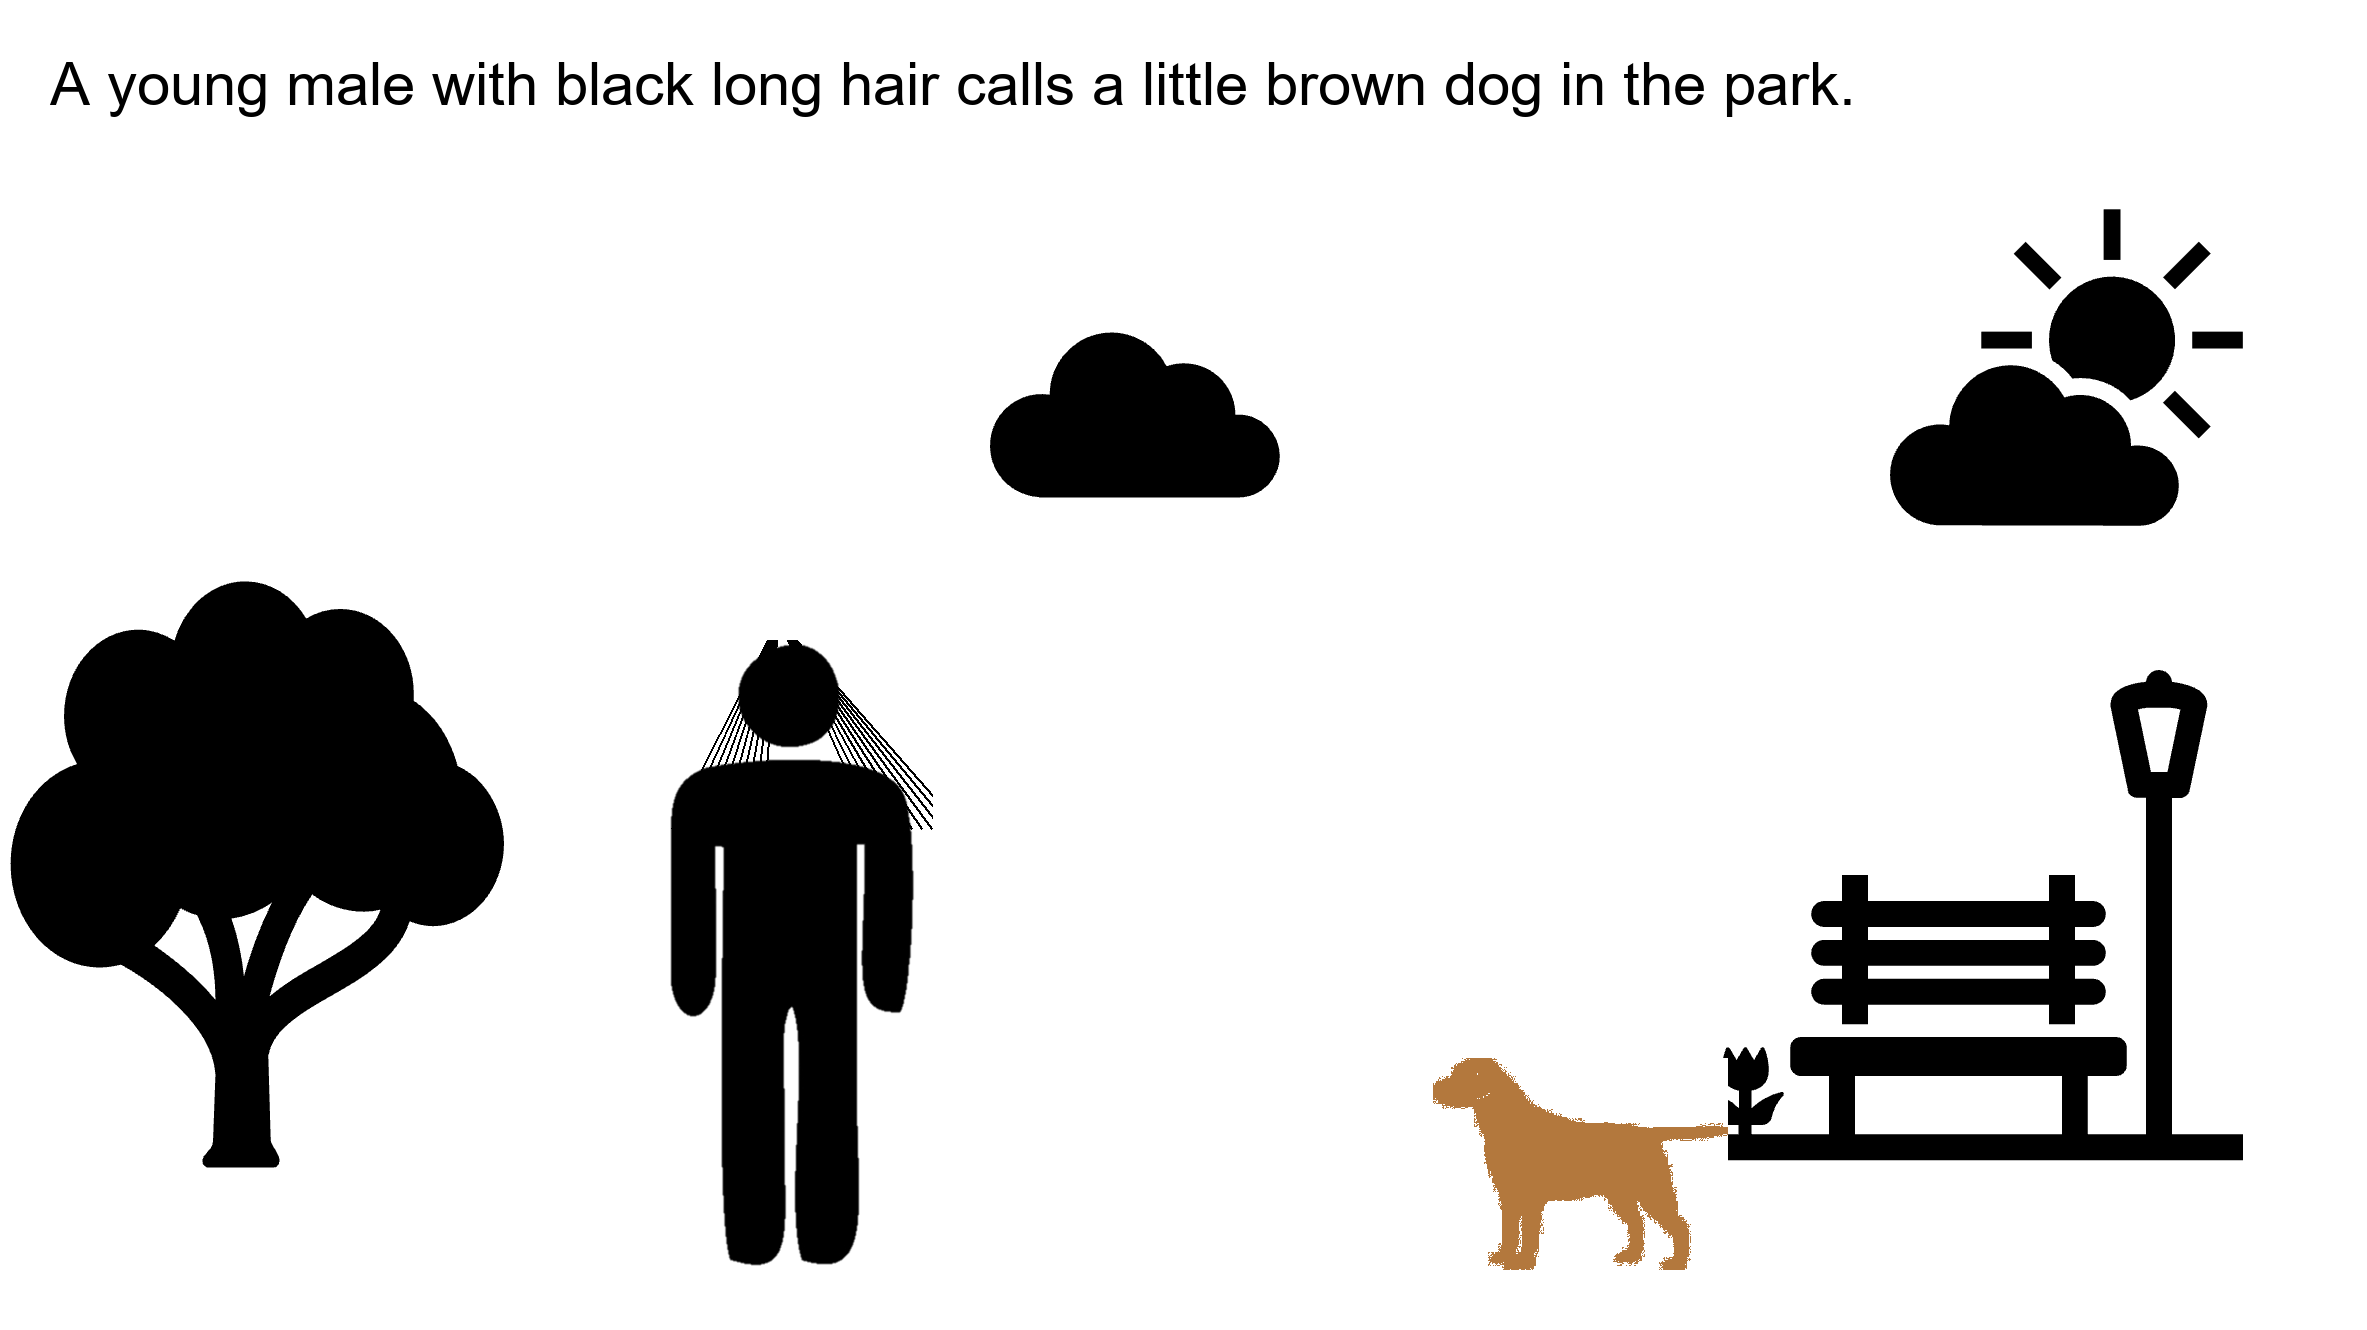

In [10]:
display(btn_condition)

We can also change the hair color of the person or the size of the animal. We choosed the golden hair and the little animal. Let's condition the model on animal is on the left, background is the park, and they are fighting.

Let's see what happened to the picture. 

Based on above conditions, the position of the person has to be the same as the animal, and the hair color of the person changed and the animal became little.

Button(description='Show conditional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle(),…

A young male with golden long hair fights a little black cat in the park.


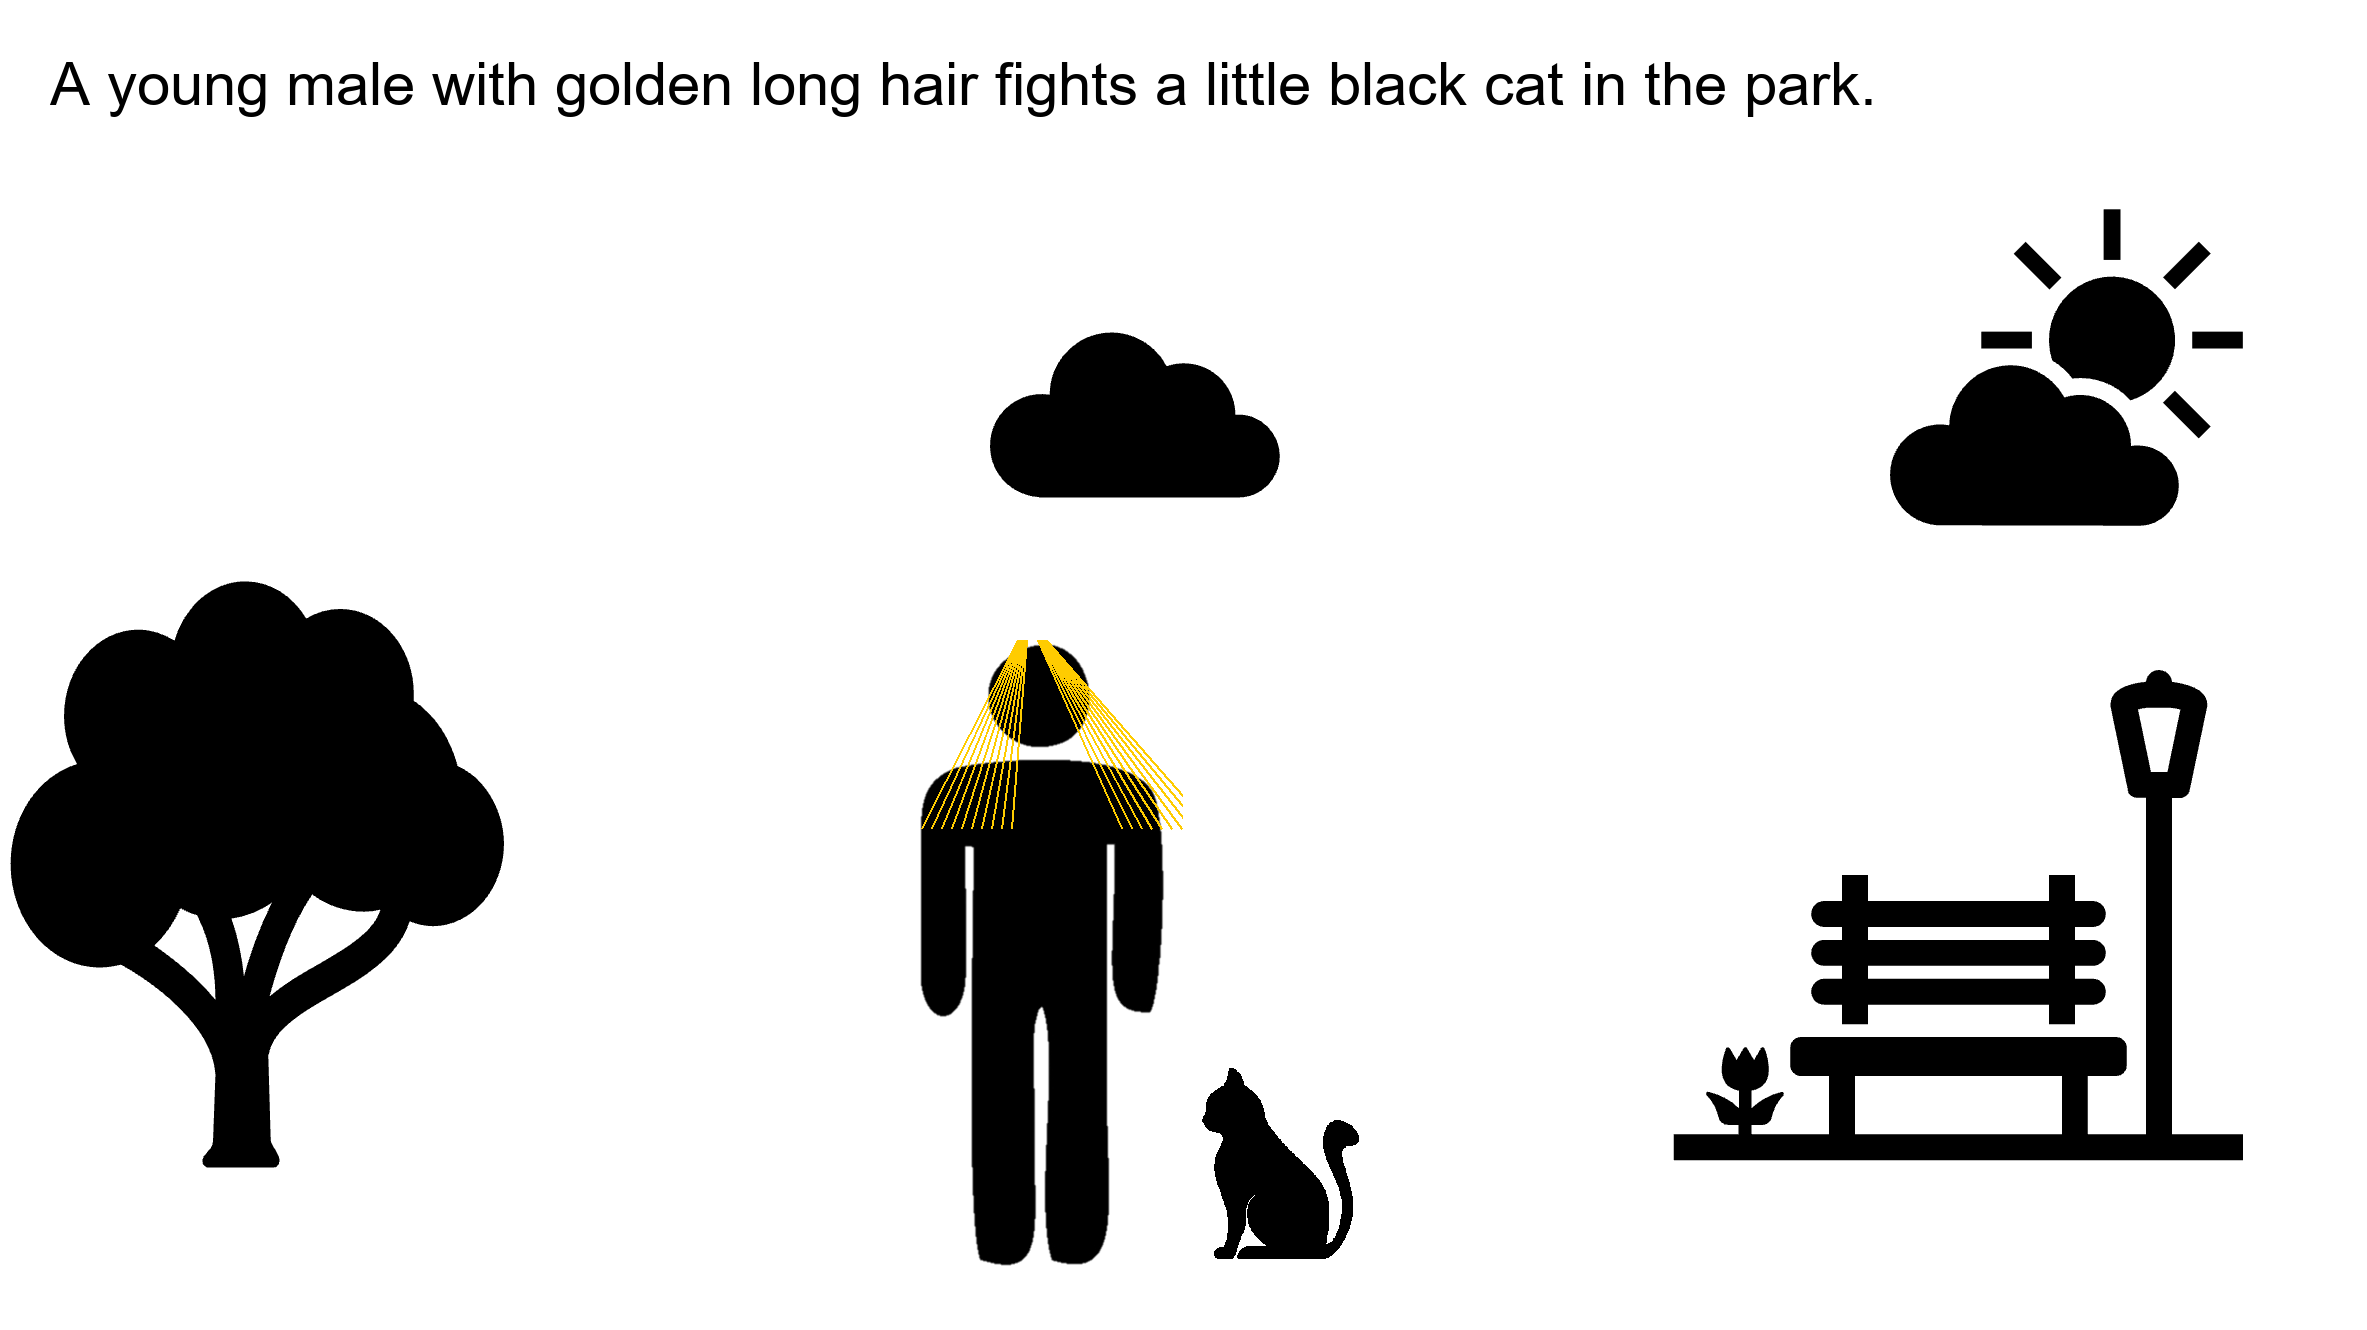

In [11]:
display(btn_condition)

### 2. Intervention model 
Do that they are in the same places of at home, what could be the interaction of them?

#### Model and generate picture
Here we choose position1 and position2 both right to indicate that they are in same location at home.

After choosing the variables and values, click "Show interventional picture", it will generate the picture of intervention model for you. <br>
In this case we can see that, at home, the female and the dog are in same place, so they can only fight and hold. <br>
The caption of this image is also generated. <br>

Button(description='Show interventional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle…

A young female with golden short hair holds a little grey cat at home.


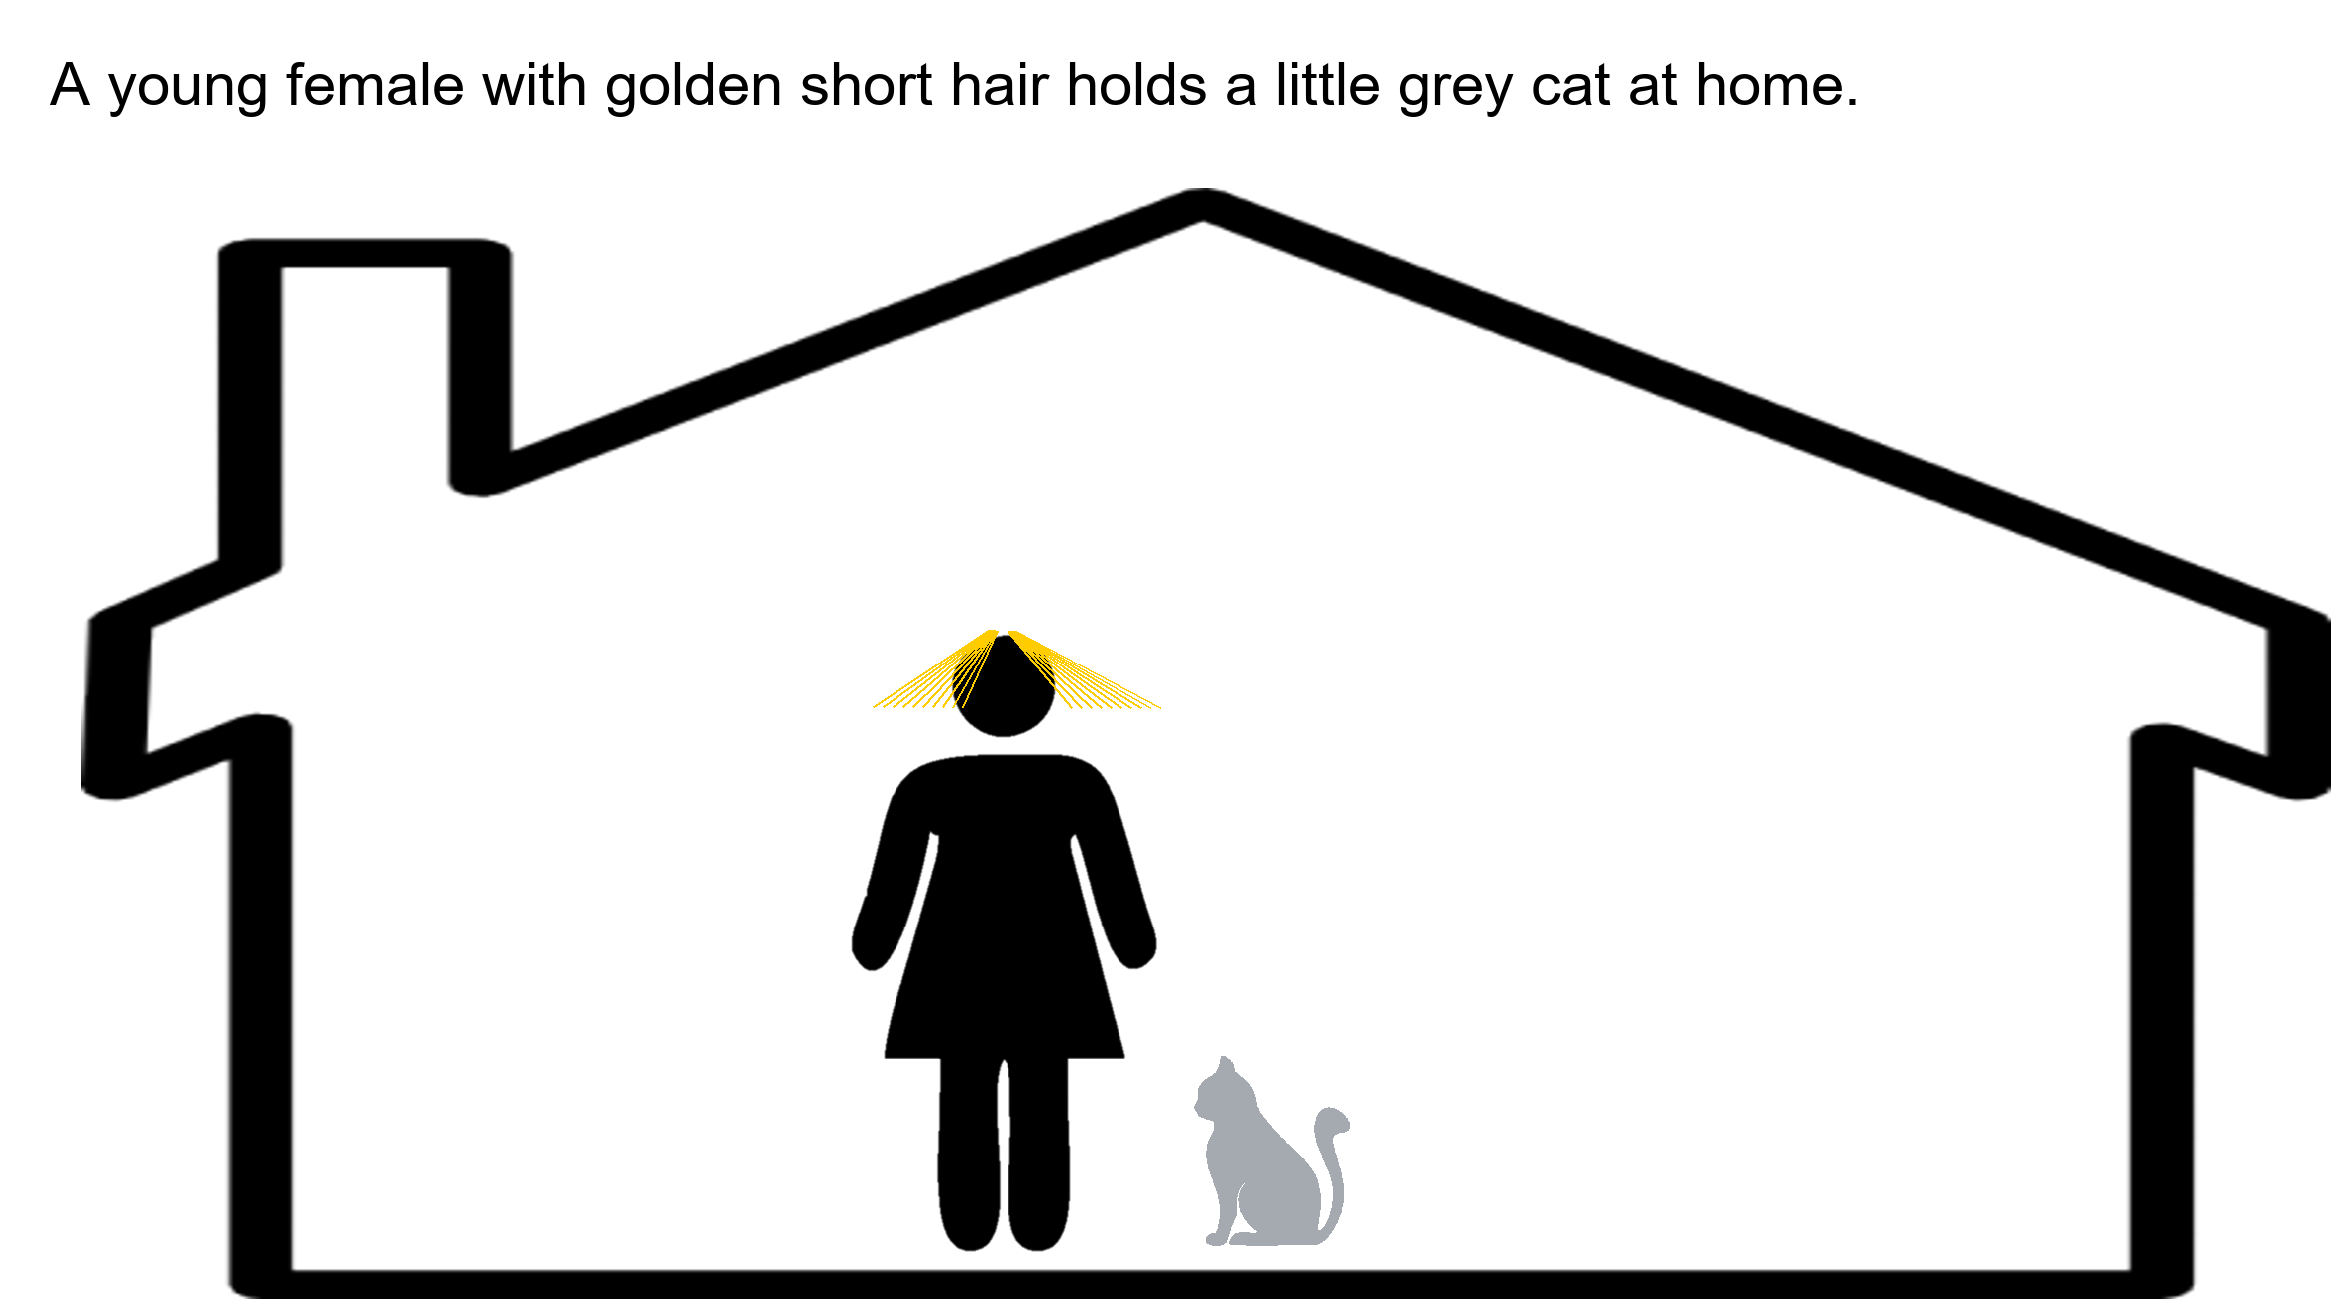

In [12]:
display(btn_intervention)

We can do the same here. We choosed the old long hair lady and the black cat in the park. Intervention is that they are fighting and the animal's postion is left. 

Let's see what happened to the picture.

The lady and the cat's appearance changed but they have some probabilities to be in different places.

Button(description='Show interventional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle…

A old female with black long hair fights a little black cat in the park.


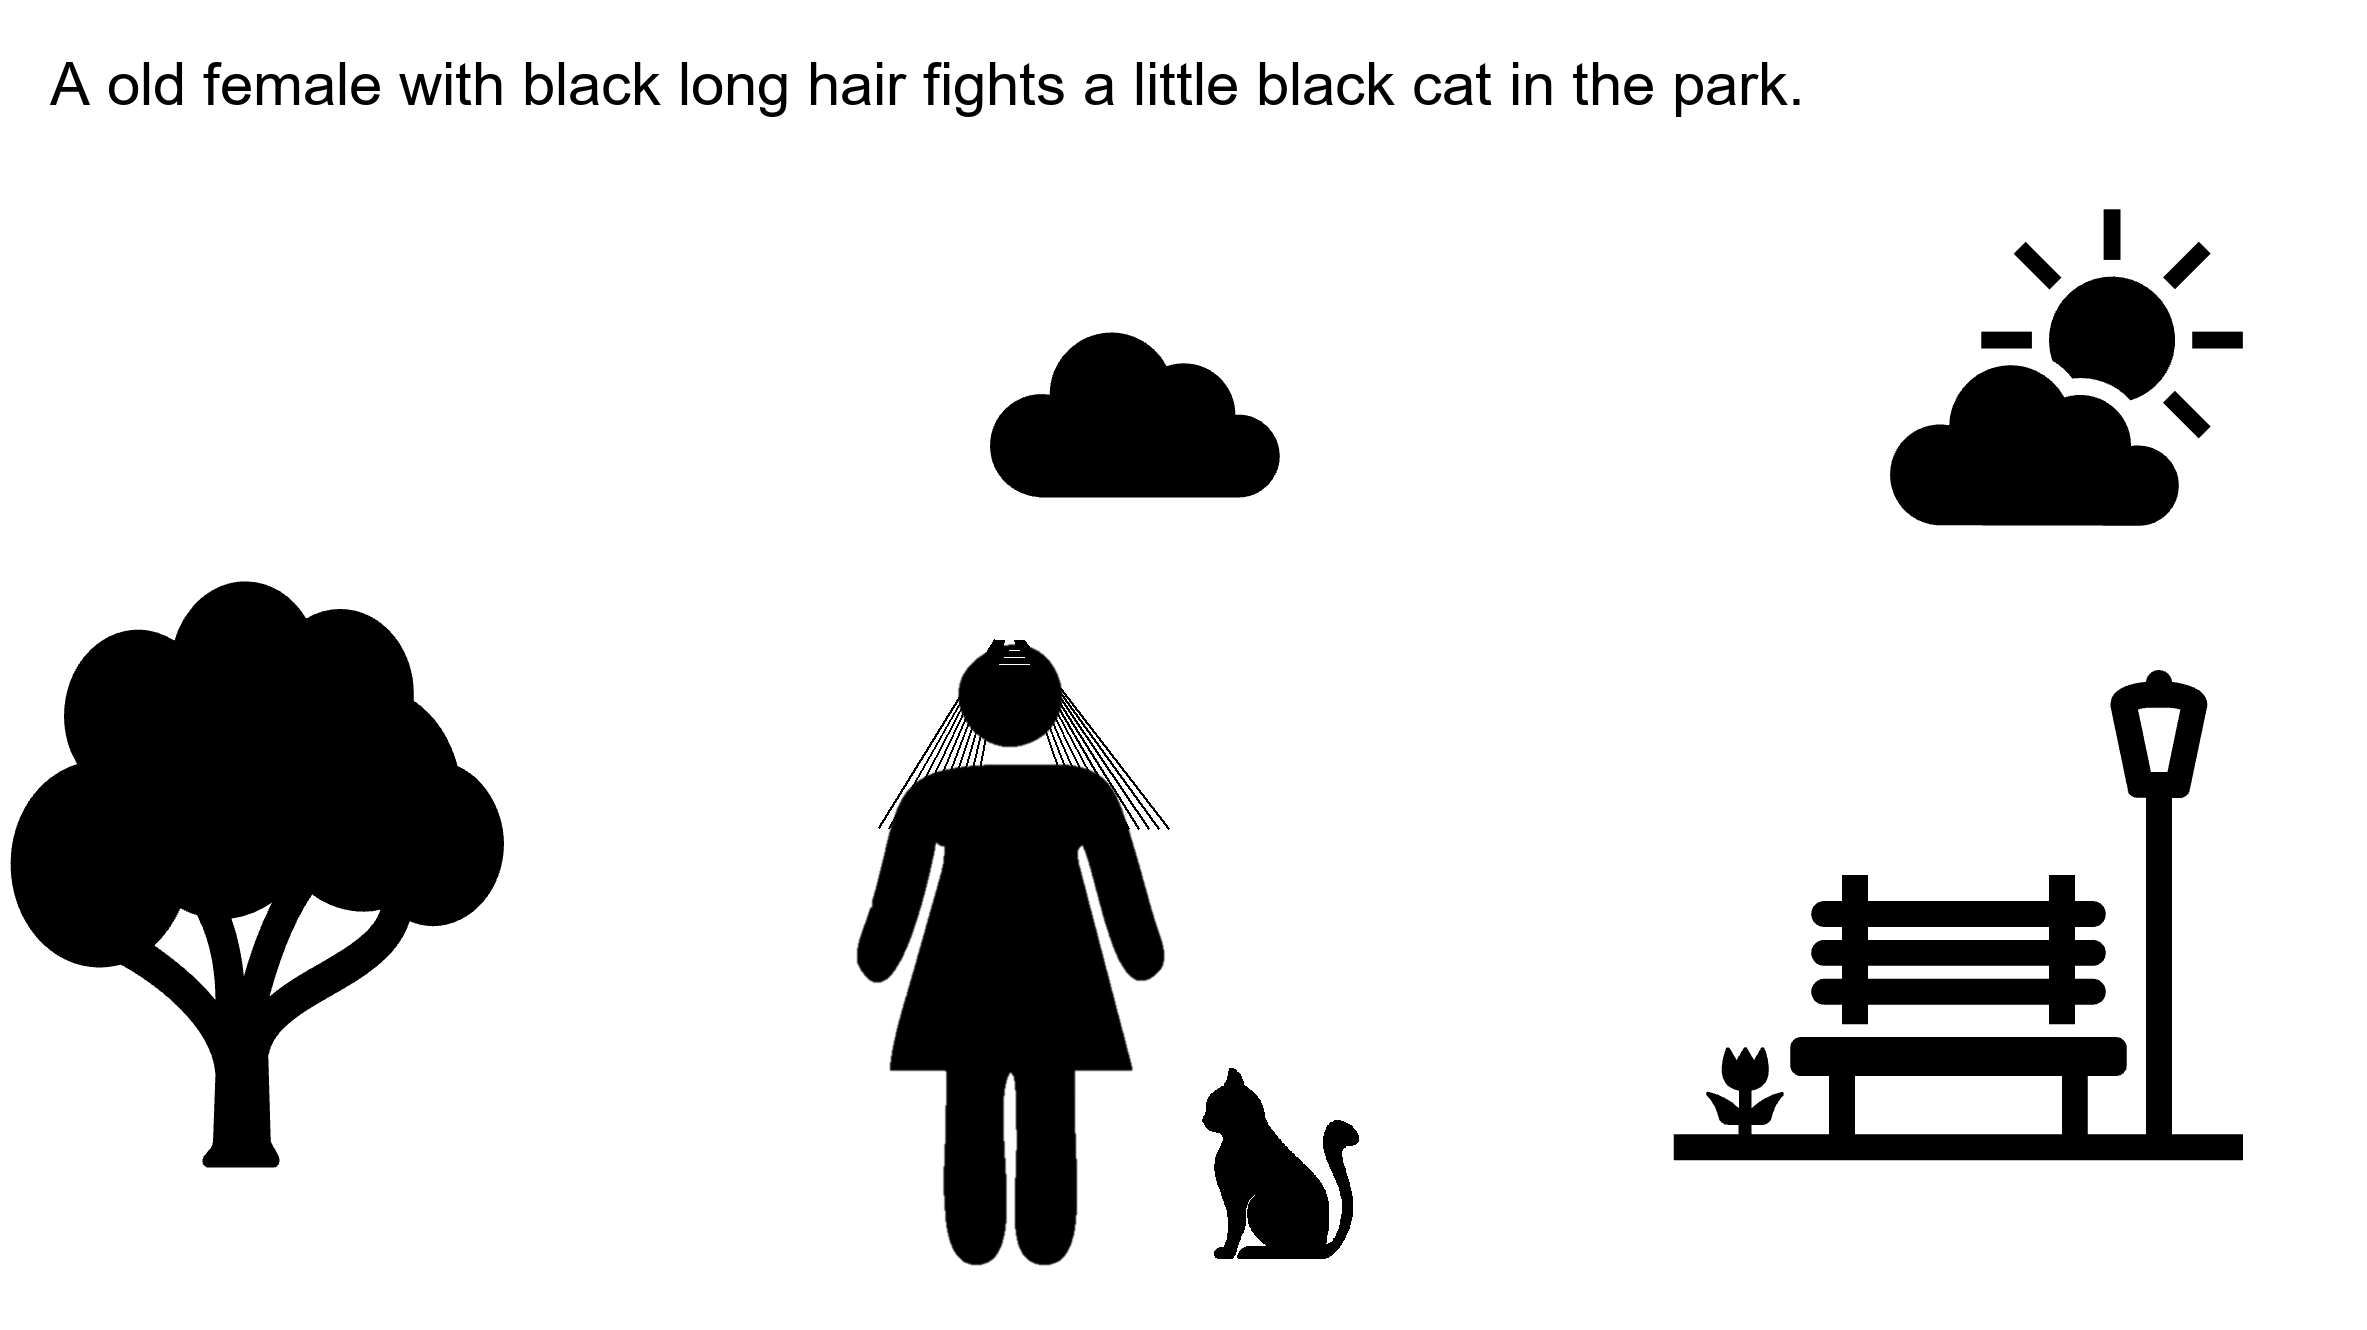

In [13]:
display(btn_intervention)